In [1]:
#baseline GloVe with CNN, LSTM CLSTM, with balanced data
#Final sheet, lets make it look cleaner by ingoring the warnings
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt
import time
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
embed_size = 300
max_features = 30000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 30 # max number of words in a question to use

In [4]:
#Load the comibed and processed imbalance data
data=pd.read_csv('CrisisNLP_CPB.csv')
data.head(5)

,label,text
0,sympathy_and_emotional_support,fuerzachile nuestro corazón oraciones con uste...
1,caution_and_advice,updated saturday downgraded super typhoon typhoon
2,injured_or_dead_people,impossible keep rising death toll links ongoin...
3,caution_and_advice,via pagasa states intensification typhoon stil...
4,other_useful_information,arutz7 watch cctv shows moment powerful earthq...


In [5]:
#randomize the data
np.random.seed(42)
data = data.sample(frac=1)
data = data.reset_index(drop=True)

In [6]:
#do a test train split 80 - 20
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(data['text'].astype(str), data['label'],
                                                    stratify=data['label'], 
                                                    test_size=0.20)

In [7]:
#Print the size of the data
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (13812,)
Test shape :  (3454,)


In [8]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=max_len)
test_X = pad_sequences(test_X, maxlen=max_len)
print(train_X.shape)

(13812, 30)


In [9]:
#transform labels into numericals
le = LabelEncoder()

train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [10]:
#Print class information 
le.classes_

array(['caution_and_advice', 'displaced_people_and_evacuations',
       'donation_needs_or_offers_or_volunteering_services',
       'infrastructure_and_utilities_damage', 'injured_or_dead_people',
       'missing_trapped_or_found_people', 'not_related_or_irrelevant',
       'other_useful_information', 'sympathy_and_emotional_support'],
      dtype=object)

In [11]:
#Define function to load Glove and create embedding matrix
#Get GLOVE from http://nlp.stanford.edu/data/glove.840B.300d.zip
def load_glove(word_index):
    EMBEDDING_FILE = 'glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE,encoding="utf-8"))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [12]:
embedding_matrix = load_glove(tokenizer.word_index)

In [13]:
# missing entries in the embedding are set using np.random.normal so we have to seed here too
debug=0
if debug:
    embedding_matrix = np.random.randn(30000,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

In [14]:
#print the shape of embedding matrix
np.shape(embedding_matrix)

(16258, 300)

In [15]:
#Function to test and train the model
def batch_run(n,model):
    n_epochs = n
    model = model
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    model.cpu()

    # Load train and test in CUDA Memory
    x_train = torch.tensor(train_X, dtype=torch.long).cpu()
    y_train = torch.tensor(train_y, dtype=torch.long).cpu()
    x_cv = torch.tensor(test_X, dtype=torch.long).cpu()
    y_cv = torch.tensor(test_y, dtype=torch.long).cpu()

    # Create Torch datasets
    train = torch.utils.data.TensorDataset(x_train, y_train)
    valid = torch.utils.data.TensorDataset(x_cv, y_cv)

    # Create Data Loaders
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

    train_loss = []
    valid_loss = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # Set model to train configuration
        model.train()
        avg_loss = 0.  
        for i, (x_batch, y_batch) in enumerate(train_loader):
            # Predict/Forward Pass
            y_pred = model(x_batch)
            # Compute loss
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() / len(train_loader)

        # Set model to validation configuration -Doesn't get trained here
        model.eval()        
        avg_val_loss = 0.
        val_preds = np.zeros((len(x_cv),len(le.classes_)))

        for i, (x_batch, y_batch) in enumerate(valid_loader):
            y_pred = model(x_batch).detach()
            avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
            # keep/store predictions
            val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()

        # Check Accuracy
        val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
        train_loss.append(avg_loss)
        valid_loss.append(avg_val_loss)
        elapsed_time = time.time() - start_time 
        print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                    epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))
    return train_loss,valid_loss,val_preds

In [16]:
#Function to plot graph for train and valid loss
def plot_graph(epochs,train_loss,valid_loss):
    fig = plt.figure(figsize=(6,6))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

In [17]:
#Function to print classification report and plot confusion matrix graph
def conf_matrix(val_preds):
    y_true = [le.classes_[x] for x in test_y]
    y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
    print (classification_report(y_true, y_pred))
    skplt.metrics.plot_confusion_matrix(
        y_true, 
        y_pred,
        figsize=(5,5),x_tick_rotation=90)

In [18]:
#Model1 - CNN
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [2, 3, 4]
        num_filters = 32
        drp = 0.2
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(drp)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x) 
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

In [19]:
#Get Model1-CNN information 
print(CNN_Text())
print (sum([param.nelement() for param in CNN_Text().parameters()]))

CNN_Text(
  (embedding): Embedding(30000, 300)
  (convs1): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(2, 300), stride=(1, 1))
    (1): Conv2d(1, 32, kernel_size=(3, 300), stride=(1, 1))
    (2): Conv2d(1, 32, kernel_size=(4, 300), stride=(1, 1))
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=96, out_features=9, bias=True)
)
4964769


In [20]:
#Model2-BiLSTM 
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        h_embedding = self.embedding(x)
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [21]:
#Get Model2-BiLSTM information 
print(BiLSTM())
print (sum([param.nelement() for param in BiLSTM().parameters()]))

BiLSTM(
  (embedding): Embedding(30000, 300)
  (lstm): LSTM(300, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=64, out_features=9, bias=True)
)
5081825


In [22]:
#Model3-CBiLSTM 
class CBiLSTM(nn.Module):
    
    def __init__(self):
        super(CBiLSTM, self).__init__()
        filter_sizes = [2, 3, 4]
        num_filters = 32
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
               
        self.hidden_size = 64
        drp = 0.1
        self.lstm = nn.LSTM(96, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        x = self.embedding(x) 
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = x.unsqueeze(1)
        
        h_lstm, _ = self.lstm(x)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [23]:
#Get Model3-CBiLSTM information
print(CBiLSTM())
print (sum([param.nelement() for param in BiLSTM().parameters()]))

CBiLSTM(
  (embedding): Embedding(30000, 300)
  (convs1): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(2, 300), stride=(1, 1))
    (1): Conv2d(1, 32, kernel_size=(3, 300), stride=(1, 1))
    (2): Conv2d(1, 32, kernel_size=(4, 300), stride=(1, 1))
  )
  (lstm): LSTM(96, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=64, out_features=9, bias=True)
)
5081825


In [24]:
batch_size = 128 # how many samples to process at once
n_epochs=10
model_name1=CNN_Text()
model_name2=BiLSTM()
model_name3=CBiLSTM()

In [25]:
#Run the model1
train_loss,valid_loss,val_preds=batch_run(n_epochs,model_name1)

Epoch 1/10 	 loss=191.9498 	 val_loss=129.9097  	 val_acc=0.6914  	 time=18.10s
Epoch 2/10 	 loss=120.8808 	 val_loss=109.4287  	 val_acc=0.7293  	 time=17.66s
Epoch 3/10 	 loss=100.8212 	 val_loss=100.1194  	 val_acc=0.7611  	 time=17.61s
Epoch 4/10 	 loss=86.9453 	 val_loss=92.5002  	 val_acc=0.7785  	 time=18.90s
Epoch 5/10 	 loss=76.3791 	 val_loss=87.0829  	 val_acc=0.7907  	 time=20.61s
Epoch 6/10 	 loss=68.3471 	 val_loss=84.2124  	 val_acc=0.7970  	 time=18.71s
Epoch 7/10 	 loss=59.9087 	 val_loss=82.1841  	 val_acc=0.7994  	 time=16.72s
Epoch 8/10 	 loss=54.5149 	 val_loss=80.5335  	 val_acc=0.8135  	 time=16.98s
Epoch 9/10 	 loss=48.9049 	 val_loss=80.9205  	 val_acc=0.8127  	 time=16.87s
Epoch 10/10 	 loss=43.5118 	 val_loss=79.1484  	 val_acc=0.8164  	 time=16.12s


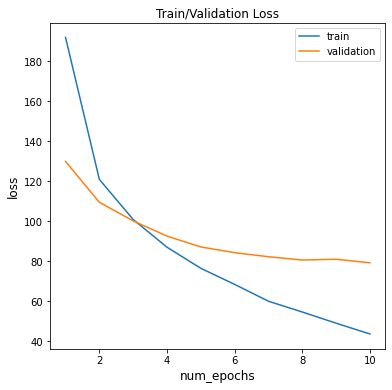

In [26]:
plot_graph(n_epochs,train_loss,valid_loss)

                                                   precision    recall  f1-score   support

                               caution_and_advice       0.79      0.88      0.83       384
                 displaced_people_and_evacuations       0.90      0.98      0.94       382
donation_needs_or_offers_or_volunteering_services       0.78      0.76      0.77       384
              infrastructure_and_utilities_damage       0.86      0.89      0.87       384
                           injured_or_dead_people       0.91      0.90      0.90       384
                  missing_trapped_or_found_people       0.95      0.97      0.96       384
                        not_related_or_irrelevant       0.73      0.65      0.69       384
                         other_useful_information       0.62      0.53      0.57       384
                   sympathy_and_emotional_support       0.76      0.79      0.78       384

                                         accuracy                           0.82      34

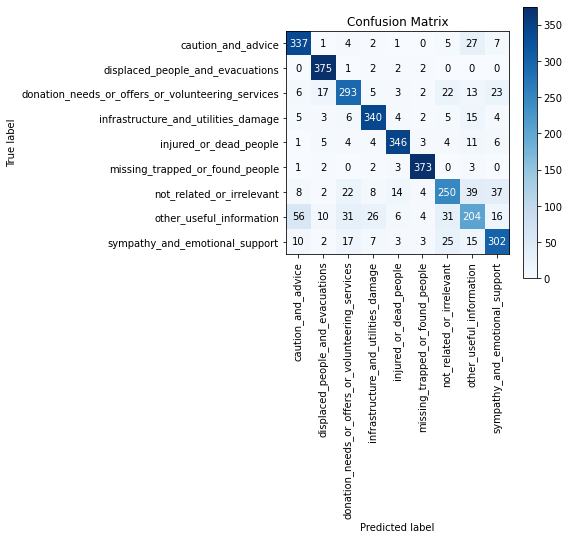

In [28]:
conf_matrix(val_preds)

In [29]:
#Run the model2
train_loss,valid_loss,val_preds=batch_run(n_epochs,model_name2)

Epoch 1/10 	 loss=235.4073 	 val_loss=158.6594  	 val_acc=0.5984  	 time=27.98s
Epoch 2/10 	 loss=135.2140 	 val_loss=120.6063  	 val_acc=0.6772  	 time=27.50s
Epoch 3/10 	 loss=107.2367 	 val_loss=107.3398  	 val_acc=0.7299  	 time=29.07s
Epoch 4/10 	 loss=91.4568 	 val_loss=97.7681  	 val_acc=0.7617  	 time=27.63s
Epoch 5/10 	 loss=79.5786 	 val_loss=93.7377  	 val_acc=0.7669  	 time=27.33s
Epoch 6/10 	 loss=69.9537 	 val_loss=87.2003  	 val_acc=0.7805  	 time=27.49s
Epoch 7/10 	 loss=61.2460 	 val_loss=84.7267  	 val_acc=0.8008  	 time=27.82s
Epoch 8/10 	 loss=53.9720 	 val_loss=84.1111  	 val_acc=0.7970  	 time=27.09s
Epoch 9/10 	 loss=45.9183 	 val_loss=82.9396  	 val_acc=0.8115  	 time=27.26s
Epoch 10/10 	 loss=40.8567 	 val_loss=84.4346  	 val_acc=0.8135  	 time=26.78s


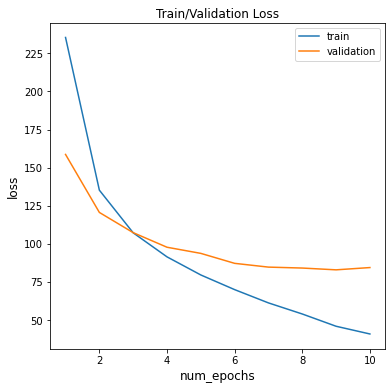

In [30]:
plot_graph(n_epochs,train_loss,valid_loss)

                                                   precision    recall  f1-score   support

                               caution_and_advice       0.84      0.83      0.83       384
                 displaced_people_and_evacuations       0.90      0.98      0.94       382
donation_needs_or_offers_or_volunteering_services       0.74      0.77      0.76       384
              infrastructure_and_utilities_damage       0.83      0.89      0.86       384
                           injured_or_dead_people       0.88      0.91      0.90       384
                  missing_trapped_or_found_people       0.96      0.96      0.96       384
                        not_related_or_irrelevant       0.68      0.69      0.69       384
                         other_useful_information       0.68      0.53      0.59       384
                   sympathy_and_emotional_support       0.78      0.77      0.77       384

                                         accuracy                           0.81      34

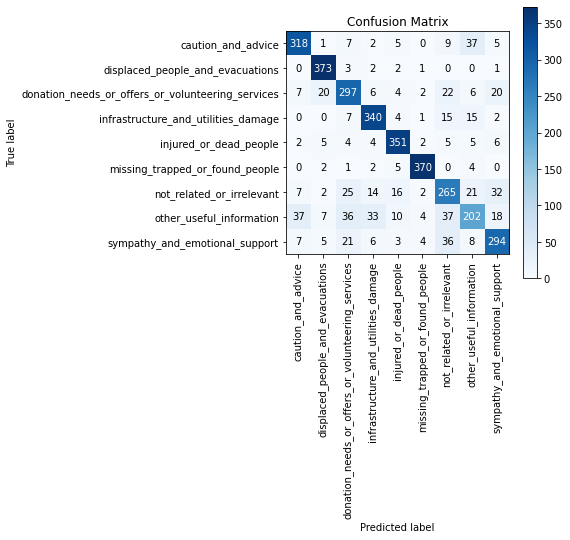

In [31]:
conf_matrix(val_preds)

In [32]:
#Run the model3
train_loss,valid_loss,val_preds=batch_run(n_epochs,model_name3)

Epoch 1/10 	 loss=190.9086 	 val_loss=119.5437  	 val_acc=0.6998  	 time=20.51s
Epoch 2/10 	 loss=99.7257 	 val_loss=93.1542  	 val_acc=0.7704  	 time=19.57s
Epoch 3/10 	 loss=70.5817 	 val_loss=85.5941  	 val_acc=0.7939  	 time=19.51s
Epoch 4/10 	 loss=52.1083 	 val_loss=84.8460  	 val_acc=0.8002  	 time=19.40s
Epoch 5/10 	 loss=38.5554 	 val_loss=86.9097  	 val_acc=0.8072  	 time=20.28s
Epoch 6/10 	 loss=27.8289 	 val_loss=92.9324  	 val_acc=0.8054  	 time=19.92s
Epoch 7/10 	 loss=19.8109 	 val_loss=99.7062  	 val_acc=0.8095  	 time=20.03s
Epoch 8/10 	 loss=16.3058 	 val_loss=107.2564  	 val_acc=0.8075  	 time=19.02s
Epoch 9/10 	 loss=11.8440 	 val_loss=117.3995  	 val_acc=0.8023  	 time=18.93s
Epoch 10/10 	 loss=9.7798 	 val_loss=128.7328  	 val_acc=0.8023  	 time=18.23s


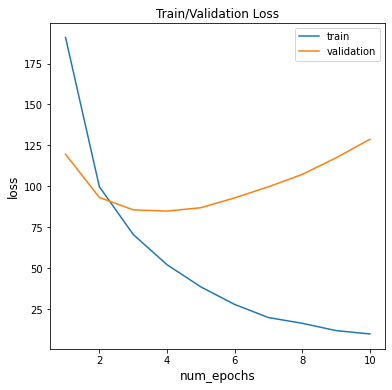

In [33]:
plot_graph(n_epochs,train_loss,valid_loss)

                                                   precision    recall  f1-score   support

                               caution_and_advice       0.84      0.86      0.85       384
                 displaced_people_and_evacuations       0.91      0.99      0.95       382
donation_needs_or_offers_or_volunteering_services       0.72      0.77      0.74       384
              infrastructure_and_utilities_damage       0.79      0.91      0.84       384
                           injured_or_dead_people       0.92      0.86      0.89       384
                  missing_trapped_or_found_people       0.96      0.97      0.97       384
                        not_related_or_irrelevant       0.66      0.65      0.66       384
                         other_useful_information       0.57      0.55      0.56       384
                   sympathy_and_emotional_support       0.88      0.65      0.75       384

                                         accuracy                           0.80      34

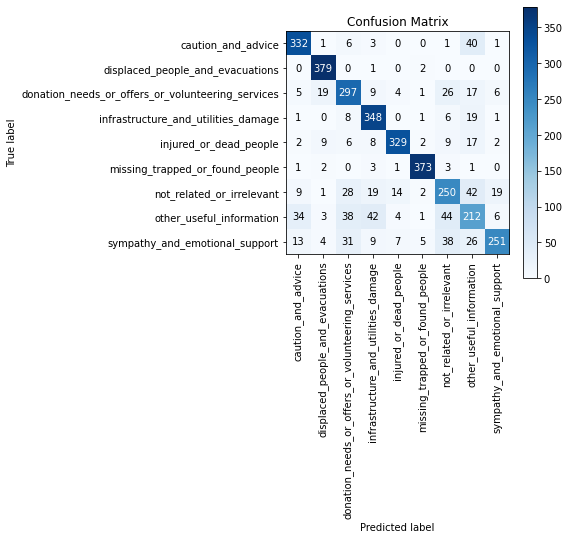

In [34]:
conf_matrix(val_preds)